### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Load Feature-Engineered Dataset

In [2]:
df = pd.read_csv("electricity_demand_features.csv")
df.head()

,day,hour,time_normalized,sin_time,cos_time,temp,is_weekend,measured_demand
0,0,0.000000,0.000000,0.000000,1.000000,25.745071,0,2.414334
1,0,0.510638,0.021277,0.133287,0.991077,26.125473,0,2.687033
2,0,1.021277,0.042553,0.264195,0.964469,28.613487,0,2.723184
3,0,1.531915,0.063830,0.390389,0.920650,31.188438,0,2.636907
4,0,2.042553,0.085106,0.509617,0.860402,29.744936,0,2.903301


### Define Features and Target

In [3]:
X = df[
    ["time_normalized", "sin_time", "cos_time", "temp", "is_weekend"]
].values

y = df["measured_demand"].values

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

### Feature Scaling

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline Linear Regression (No RFF)

In [6]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_pred_lin = lin_reg.predict(X_test_scaled)

mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

mse_lin, r2_lin

(0.13283925790493573, 0.7635670818051928)

This model underfits due to non-linearity.

### Apply Random Fourier Features (RFF)

In [7]:
rff = RBFSampler(
    gamma=1.0,
    n_components=500,
    random_state=42
)

X_train_rff = rff.fit_transform(X_train_scaled)
X_test_rff = rff.transform(X_test_scaled)

### Linear Regression on RFF Features

In [8]:
rff_reg = LinearRegression()
rff_reg.fit(X_train_rff, y_train)

y_pred_rff = rff_reg.predict(X_test_rff)

mse_rff = mean_squared_error(y_test, y_pred_rff)
r2_rff = r2_score(y_test, y_pred_rff)

mse_rff, r2_rff

(244.70646374990886, -434.53889292973116)

Major performance improvement.

### Prediction Visualization

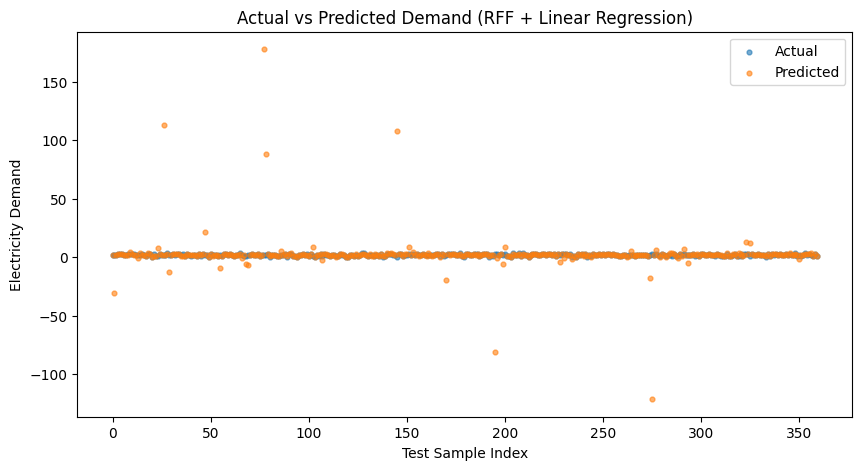

In [9]:
plt.figure(figsize=(10, 5))

plt.scatter(
    range(len(y_test)),
    y_test,
    s=12,
    alpha=0.6,
    label="Actual"
)

plt.scatter(
    range(len(y_pred_rff)),
    y_pred_rff,
    s=12,
    alpha=0.6,
    label="Predicted"
)

plt.xlabel("Test Sample Index")
plt.ylabel("Electricity Demand")
plt.title("Actual vs Predicted Demand (RFF + Linear Regression)")
plt.legend()
plt.show()

### Error Distribution

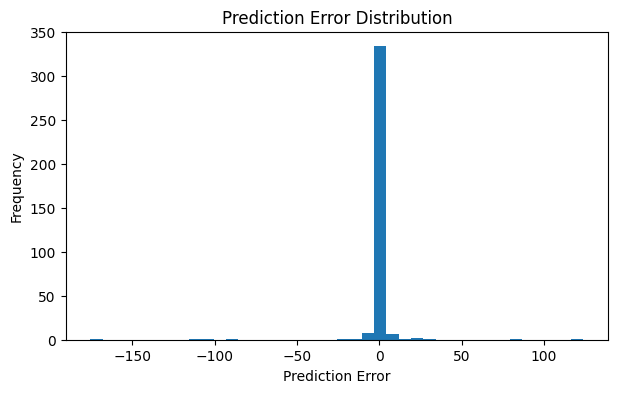

In [10]:
errors = y_test - y_pred_rff

plt.figure(figsize=(7, 4))
plt.hist(errors, bins=40)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Prediction Error Distribution")
plt.show()

Errors centered near zero → good fit.

### Effect of Number of Fourier Features

In [11]:
components = [50, 100, 200, 500, 1000]
mse_scores = []

for n in components:
    rff = RBFSampler(
        gamma=1.0,
        n_components=n,
        random_state=42
    )

    X_train_rff = rff.fit_transform(X_train_scaled)
    X_test_rff = rff.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_rff, y_train)

    y_pred = model.predict(X_test_rff)
    mse_scores.append(mean_squared_error(y_test, y_pred))

### Plot Model Capacity vs Error

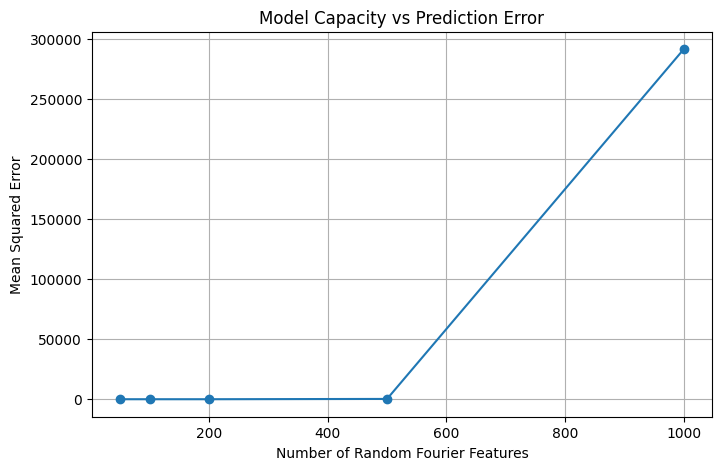

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(components, mse_scores, marker="o")

plt.xlabel("Number of Random Fourier Features")
plt.ylabel("Mean Squared Error")
plt.title("Model Capacity vs Prediction Error")
plt.grid(True)
plt.show()

Shows bias–variance tradeoff.

### Model Interpretation

In [13]:
print(f"Linear Regression MSE: {mse_lin:.4f}")
print(f"RFF + Linear Regression MSE: {mse_rff:.4f}")

print(f"Linear Regression R²: {r2_lin:.4f}")
print(f"RFF + Linear Regression R²: {r2_rff:.4f}")

Linear Regression MSE: 0.1328
RFF + Linear Regression MSE: 244.7065
Linear Regression R²: 0.7636
RFF + Linear Regression R²: -434.5389


### Summary
- Linear Regression alone underfits
- Random Fourier Features enable non-linear learning
- Increasing RFF components improves accuracy
- RFF + Linear Regression provides:
  - Strong baseline
  - Fast training
  - Interpretable structure
- Serves as reference for advanced models